## 使用正弦函数和一些可加性噪音来生成序列数据，时间步为1,2，...，1000。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

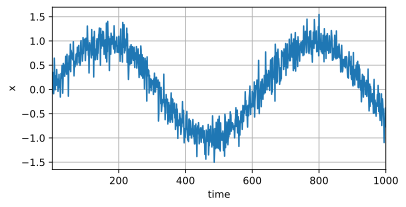

In [2]:
T = 1000  # 总产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [8]:
x.shape

torch.Size([1000])

## 我们将这个序列转换为模型的“特征—标签”（feature-label）对。基于嵌入维度τ，我们将数据映射为数据对yt=xt和Xt=[xt-τ,...,xt-1]。

## 你可能已经注意到，这比我们提供的数据样本少了τ个，因为我们没有足够的历史记录来描述前τ个数据样本。一个简单的解决办法是：如果拥有足够长的序列就丢弃这几项；另一个方法是用零填充序列。在这里，我们仅使用前600个“特征--标签”对进行训练。

In [3]:
tau = 4
features =torch.zeros((T - tau, tau))  # (996, 4)
for i in range(tau):
    features[:, i] = x[i: T - tau + i]  # (features[:, 0]=x[0:996]
labels = x[tau:].reshape((-1, 1))  # (996, 1)

batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                           batch_size, is_train=True)

## 在这里，我们使用一个相当简单的架构模型：一个拥有两个全连接层的多层感知机，ReLU激活函数和平方损失

In [9]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                       nn.ReLU(),
                       nn.Linear(10, 1))
    net.apply(init_weights)
    return net

# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
loss = nn.MSELoss(reduction='none')

## 训练模型

In [10]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
             f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 0.057619
epoch 2, loss: 0.053768
epoch 3, loss: 0.050845
epoch 4, loss: 0.054830
epoch 5, loss: 0.048750


# 预测
## 由于训练损失很小，因此我们期望模型能有很好的工作效果。让我们看看这在实践中意味着什么。首先是检查模型预测下一个时间步的能力，也就是单步预测（one-step-ahead prediction）

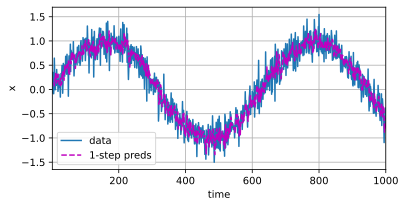

In [11]:
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy()], 'time',
        'x', legend=['data', '1-step preds'], xlim=[1, 1000],
        figsize=(6, 3))

## 使用我们自己的预测（而不是原始数据）来进行多步预测。

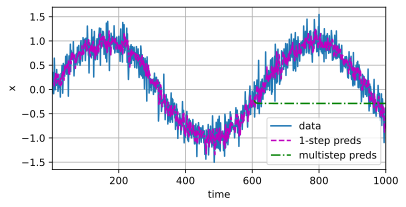

In [13]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
         [x.detach().numpy(), onestep_preds.detach().numpy(),
          multistep_preds[n_train + tau:].detach().numpy()], 'time',
         'x', legend=['data', '1-step preds', 'multistep preds'],
         xlim=[1, 1000], figsize=(6, 3))